## Learning to Rank

Pointwise: One instance of the set is considered at a time, use any kind of classifier or regressor to predict how relevant it is in the current query. Use each points predicted relevance to order the set.

Pairwise: A pair of instances is chosen and the order of those two is predicted. Repeat this for each pair of the query to find the final order of the entire query.

Listwise: Many or all instances are considered at once. Try to find the optimal order.

- https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python
- https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost
- https://developer.nvidia.com/blog/learning-to-rank-with-xgboost-and-gpu/#:~:text=XGBoost%20is%20a%20widely%20used,descent%20using%20an%20objective%20function.
- https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [5]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns


# Data Preparation (Pre-processing)

In [7]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/hotels_data.csv')
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod
0,Hotel Indonesia Kempinski Jakarta,5.0,8.9,4363,2.480.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Food and Drinks\nA la carte breakfast\nA la ca...
1,"The Langham, Jakarta",5.0,8.8,238,3.823.600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...
2,Manhattan Hotel,5.0,8.5,8405,6.231.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Hotel Services\nBellhop\nConcierge\nMoney chan...
3,Aloft South Jakarta,4.0,8.9,424,762.300,Nearby Places\n\nSouthside Rooftop Bar & Loung...,Public Facilities\nParking\nCoffee shop\nEleva...
4,"The Mayflower, Jakarta - Marriott Executive Ap...",5.0,9.0,393,1.756.254,Nearby Places\n\nSudirman Plaza\nBusiness\n2 m...,Food and Drinks\nA la carte breakfast\nA la ca...


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
facilities_columns = ['Food and Drinks','Hotel Services','In-room Facilities', 'Business Facilities', 'Nearby Facilities', 'Public Facilities', 'General', 'Things to Do', 'Accessibilty', 'Connectivity', 'Transportation', 'Kids and Pets', 'Sports and Recreations', 'Shuttle Service']

facilities_columns.reverse()

for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Facil + Akomod'].splitlines() 
    #iterate over fasil and akomod

    i = 0
    count = 0

    for  item in reversed(arr):
      count += 1
      if item in facilities_columns:
        df.at[index,item ] = count
        count = 0
        i += 1

In [10]:
df = df.fillna(0)

In [11]:
for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Places Nearby'].splitlines() 
    
    #iterate over fasil and akomod

    i = 0
    count = 0
    
    for ind, item in enumerate(arr):
        itemsplits = item.split()
        for x in itemsplits:
            if x.isdigit():
                if itemsplits[1] == "km":
                    meters = itemsplits[0] * 1000
                else:
                    meters = itemsplits[0]
                    
                if meters.isdigit():
                    df.at[index,arr[ind-1]] = meters
                    #print(meters)

In [12]:
print(df.columns)

Index(['Hotel', 'Star', 'Rating', 'Reviews', 'Harga', 'Places Nearby',
       'Facil + Akomod', 'Shuttle Service', 'Sports and Recreations',
       'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty',
       'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities',
       'Business Facilities', 'In-room Facilities', 'Hotel Services',
       'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark'],
      dtype='object')


In [13]:
df.Harga = df['Harga'].str.replace('.','', regex = True)
df.Harga = df['Harga'].str.replace(',','.', regex = True)
df.Harga = df['Harga'].astype(float).astype(int)

df.Reviews = df['Reviews'].str.replace('.','', regex = True)
df.Reviews = df['Reviews'].str.replace(',','.', regex = True)
df.Reviews = df['Reviews'].astype(float).astype(int)

In [14]:
df = df.fillna(10000)

In [15]:
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [16]:
df.dtypes

Hotel                     float64
Star                      float64
Rating                    float64
Reviews                     int64
Harga                       int64
Places Nearby             float64
Facil + Akomod            float64
Shuttle Service           float64
Sports and Recreations    float64
Kids and Pets             float64
Transportation            float64
Connectivity              float64
Accessibilty              float64
Things to Do              float64
General                   float64
Public Facilities         float64
Nearby Facilities         float64
Business Facilities       float64
In-room Facilities        float64
Hotel Services            float64
Food and Drinks           float64
Fast Food                   int64
Shop & Gifts                int64
Business                    int64
Transportation Hub          int64
Casual Dining               int64
Nightlife                   int64
Park & Zoo                  int64
Public Service              int64
Arts & Science

In [17]:
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,NaN,5.0,8.9,4363,2480500,NaN,NaN,2.0,3.0,4.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,NaN,5.0,8.8,238,3823600,NaN,NaN,0.0,2.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,NaN,5.0,8.5,8405,6231500,NaN,NaN,2.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,NaN,4.0,8.9,424,762300,NaN,NaN,0.0,2.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,NaN,5.0,9.0,393,1756254,NaN,NaN,2.0,3.0,7.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


# Modelling

## Declare feature vector and target variable

In [18]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel                   0 non-null      float64
 1   Star                    89 non-null     float64
 2   Rating                  89 non-null     float64
 3   Reviews                 89 non-null     int64  
 4   Harga                   89 non-null     int64  
 5   Places Nearby           0 non-null      float64
 6   Facil + Akomod          0 non-null      float64
 7   Shuttle Service         89 non-null     float64
 8   Sports and Recreations  89 non-null     float64
 9   Kids and Pets           89 non-null     float64
 10  Transportation          89 non-null     float64
 11  Connectivity            89 non-null     float64
 12  Accessibilty            89 non-null     float64
 13  Things to Do            89 non-null     float64
 14  General                 89 non-null     floa

## Data Splitting

In [19]:
X = df[['Star','Reviews','Harga','Shuttle Service','Sports and Recreations', 'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty', 'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities', 'Business Facilities', 'In-room Facilities', 'Hotel Services', 'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business', 'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo', 'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport', 'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe', 'Entertainment', 'Food Court', 'Sight & Landmark' ]]
y = df['Rating']

In [20]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
dev_X, val_X, dev_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Light GBM

In [21]:
#import lightgbm as lgb
#clf = lgb.lambdarank()
#clf.fit(X_train, y_train)

def run_lgb(X_train, X_test, y_train, y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(X, label=y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return model, evals_result #pred_test_y

In [22]:
model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's rmse: 0.215743	valid_1's rmse: 0.225939
[300]	training's rmse: 0.197041	valid_1's rmse: 0.195774
[450]	training's rmse: 0.183802	valid_1's rmse: 0.176048
[600]	training's rmse: 0.173104	valid_1's rmse: 0.161153
[750]	training's rmse: 0.164095	valid_1's rmse: 0.149052
[900]	training's rmse: 0.156443	valid_1's rmse: 0.140348
[1050]	training's rmse: 0.149814	valid_1's rmse: 0.132575
[1200]	training's rmse: 0.144666	valid_1's rmse: 0.127293
[1350]	training's rmse: 0.1401	valid_1's rmse: 0.122706
[1500]	training's rmse: 0.136271	valid_1's rmse: 0.119085
[1650]	training's rmse: 0.132933	valid_1's rmse: 0.116051
[1800]	training's rmse: 0.12984	valid_1's rmse: 0.113486
[1950]	training's rmse: 0.127116	valid_1's rmse: 0.111052
[2100]	training's rmse: 0.124525	valid_1's rmse: 0.10914
[2250]	training's rmse: 0.121999	valid_1's rmse: 0.107436
[2400]	training's rmse: 0.11953	valid_1's rmse: 0.105464
[2550]	training's rm

In [23]:
y_pred = model.predict(X)
print(y_pred)

[8.77015561 8.77303028 8.60685983 8.62277989 8.92629469 8.6550264
 8.57596281 8.63500569 8.93792602 8.78559359 8.6987856  8.22492685
 8.20992593 8.71180937 8.61940601 8.72573797 8.61961742 8.76317059
 8.62066604 8.77534503 8.59688072 8.52276873 8.51205612 8.52715473
 8.33550767 8.72573797 8.86479613 8.51205612 8.75663934 8.47887462
 8.61217682 8.81192075 8.55924098 8.46275883 8.61812452 8.59990223
 8.63514106 8.80662031 8.47116276 8.6329524  8.56406458 8.54031493
 8.53143646 8.51477517 8.57797492 8.9439115  8.78030563 8.61072482
 8.61641218 8.5576015  8.55766759 8.55766759 8.5074464  8.03318861
 8.29790307 8.39422799 8.50293503 8.57442573 8.62178246 8.51662031
 8.68448915 8.5383794  8.50801824 8.55950558 8.66245568 8.31712762
 8.22810065 8.46661238 8.584623   8.48587306 8.61822259 8.85796176
 8.6902322  8.3316678  8.44054742 8.46597241 8.87482863 8.48239166
 8.18377505 8.60236434 8.42475601 8.1480366  8.6169668  8.01015032
 8.03302136 8.81119184 8.11277148 8.37651043 8.18156748]


In [24]:
'''
# feature importance
print("Features Importance...")
gain = model.feature_importance('Rating')
featureimp = pd.DataFrame({'Rating':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'Rating':100 * gain / gain.sum()}).sort_values('Rating', ascending=False)
print(featureimp[:50])
'''

'\n# feature importance\nprint("Features Importance...")\ngain = model.feature_importance(\'Rating\')\nfeatureimp = pd.DataFrame({\'Rating\':model.feature_name(), \n                   \'split\':model.feature_importance(\'split\'), \n                   \'Rating\':100 * gain / gain.sum()}).sort_values(\'Rating\', ascending=False)\nprint(featureimp[:50])\n'

In [48]:
y_pred = model.predict(X)
print(y_pred)

[8.77015561 8.77303028 8.60685983 8.62277989 8.92629469 8.6550264
 8.57596281 8.63500569 8.93792602 8.78559359 8.6987856  8.22492685
 8.20992593 8.71180937 8.61940601 8.72573797 8.61961742 8.76317059
 8.62066604 8.77534503 8.59688072 8.52276873 8.51205612 8.52715473
 8.33550767 8.72573797 8.86479613 8.51205612 8.75663934 8.47887462
 8.61217682 8.81192075 8.55924098 8.46275883 8.61812452 8.59990223
 8.63514106 8.80662031 8.47116276 8.6329524  8.56406458 8.54031493
 8.53143646 8.51477517 8.57797492 8.9439115  8.78030563 8.61072482
 8.61641218 8.5576015  8.55766759 8.55766759 8.5074464  8.03318861
 8.29790307 8.39422799 8.50293503 8.57442573 8.62178246 8.51662031
 8.68448915 8.5383794  8.50801824 8.55950558 8.66245568 8.31712762
 8.22810065 8.46661238 8.584623   8.48587306 8.61822259 8.85796176
 8.6902322  8.3316678  8.44054742 8.46597241 8.87482863 8.48239166
 8.18377505 8.60236434 8.42475601 8.1480366  8.6169668  8.01015032
 8.03302136 8.81119184 8.11277148 8.37651043 8.18156748]


## XGBoost























In [25]:
def run_xgb(train_X, train_y, val_X, val_y):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    #dtest = xgb.DMatrix(test_X)
    #xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return  model_xgb #, xgb_pred_y,

In [26]:
# Training XGB
model_xgb = run_xgb(dev_X, dev_y, val_X, val_y)
print("XGB Training Completed...")

[0]	train-rmse:8.05772	valid-rmse:8.02447
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:7.30798	valid-rmse:7.27483
[200]	train-rmse:6.6282	valid-rmse:6.59516
[300]	train-rmse:6.01222	valid-rmse:5.97931
[400]	train-rmse:5.45341	valid-rmse:5.42063
[500]	train-rmse:4.94632	valid-rmse:4.91369
[600]	train-rmse:4.4872	valid-rmse:4.45474
[700]	train-rmse:4.07081	valid-rmse:4.03853
[800]	train-rmse:3.69316	valid-rmse:3.66108
[900]	train-rmse:3.35051	valid-rmse:3.31866
[1000]	train-rmse:3.03986	valid-rmse:3.00827
[1100]	train-rmse:2.75847	valid-rmse:2.72716
[1200]	train-rmse:2.50399	valid-rmse:2.47299
[1300]	train-rmse:2.27336	valid-rmse:2.2427
[1400]	train-rmse:2.06426	valid-rmse:2.03399
[1500]	train-rmse:1.87494	valid-rmse:1.8451
[1600]	train-rmse:1.70343	valid-rmse:1.67382
[1700]	train-rmse:1.54837	valid-rmse:1.51913
[1800]	train-rmse:1.40776	valid-rmse:1.37877
[1900]	train-rm

## Catboost

In [27]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [28]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 0.2381980	test: 0.2711085	best: 0.2711085 (0)	total: 58.8ms	remaining: 29.3s


50:	learn: 0.1259337	test: 0.2309285	best: 0.2309285 (50)	total: 394ms	remaining: 3.47s
100:	learn: 0.0697623	test: 0.2200408	best: 0.2198964 (97)	total: 727ms	remaining: 2.87s
150:	learn: 0.0390883	test: 0.2162348	best: 0.2162348 (150)	total: 1.07s	remaining: 2.49s
200:	learn: 0.0212079	test: 0.2142854	best: 0.2142854 (200)	total: 1.78s	remaining: 2.65s
250:	learn: 0.0112001	test: 0.2135251	best: 0.2135251 (250)	total: 2.6s	remaining: 2.58s
300:	learn: 0.0059961	test: 0.2131350	best: 0.2131350 (300)	total: 3.48s	remaining: 2.3s
350:	learn: 0.0032159	test: 0.2128927	best: 0.2128897 (349)	total: 4.37s	remaining: 1.85s
400:	learn: 0.0017157	test: 0.2126824	best: 0.2126824 (400)	total: 5.27s	remaining: 1.3s
450:	learn: 0.0009142	test: 0.2124871	best: 0.2124871 (450)	total: 6.09s	remaining: 662ms
499:	learn: 0.0004937	test: 0.2123726	best: 0.2123726 (499)	total: 6.9s	remaining: 0us

bestTest = 0.2123726103
bestIteration = 499



In [49]:
y_pred = cb_model.predict(X)
print(y_pred)

[8.89935876 8.79961565 8.70826987 8.89926658 8.99928032 8.5997735
 8.59974953 8.59647861 8.68731569 8.79947156 8.69998647 8.10112473
 8.10084603 8.52044301 8.60008238 8.60018298 8.65355755 8.69977722
 8.60011532 8.79934927 8.60000546 8.5001135  8.49999405 8.50004642
 8.53357185 8.59996125 8.7469211  8.49999405 8.89922761 8.40045536
 8.69959177 8.79949649 8.50045251 8.48468709 8.69971372 8.59977461
 8.60016069 8.9001125  8.40035411 8.6993092  8.50001305 8.53714549
 8.59952645 8.6032329  8.50027678 8.76715815 8.70006719 8.50022439
 8.59973765 8.59983435 8.59998764 8.59998764 8.50002851 8.46828229
 8.20076623 8.3006593  8.48475973 8.50019889 8.59991012 8.59972238
 8.79957626 8.50022055 8.59967491 8.53768254 8.79934254 8.30077683
 8.44922942 8.50005689 8.59975981 8.50016701 8.69952447 8.89951664
 8.79917286 8.30048146 8.40033287 8.59960486 8.99916423 8.49997165
 8.51987268 8.69955279 8.40030546 8.00087328 8.50057525 8.10065115
 7.9008031  8.89945941 7.80155851 8.40039795 8.34757377]


pred_test_cat = np.expm1(cb_model.predict(X))
print(pred_test_cat)

# Tensorflow Regression

In [29]:
df = df.drop(['Hotel', 'Places Nearby', 'Facil + Akomod'], axis=1)
df

,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,5.0,8.9,4363,2480500,2.0,3.0,4.0,4.0,5.0,6.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,5.0,8.8,238,3823600,0.0,2.0,3.0,4.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,5.0,8.5,8405,6231500,2.0,3.0,3.0,7.0,6.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,4.0,8.9,424,762300,0.0,2.0,0.0,3.0,0.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,5.0,9.0,393,1756254,2.0,3.0,7.0,6.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.0,7.9,11026,385200,2.0,0.0,0.0,4.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
85,5.0,8.9,1511,2420000,2.0,0.0,0.0,8.0,3.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
86,4.0,7.8,517,688000,0.0,0.0,0.0,0.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
87,4.0,8.4,2717,431250,2.0,3.0,0.0,5.0,4.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [30]:
df2 = df
df3 = df

## Data Preparation

In [50]:
train_dataset = df.loc[:70]
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rating')
test_labels = test_features.pop('Rating')

## DNN Model

In [32]:
def build_and_compile_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
      ])

    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [51]:
print(train_features.info)

<bound method DataFrame.info of     Star  Reviews    Harga  Shuttle Service  Sports and Recreations  \
0    5.0     4363  2480500              2.0                     3.0   
1    5.0      238  3823600              0.0                     2.0   
2    5.0     8405  6231500              2.0                     3.0   
3    4.0      424   762300              0.0                     2.0   
4    5.0      393  1756254              2.0                     3.0   
..   ...      ...      ...              ...                     ...   
66   3.0     4848   675000              0.0                     0.0   
67   3.0     9343   638000              0.0                     0.0   
68   4.0     3808   778000              0.0                     3.0   
69   4.0     3025   710888              2.0                     3.0   
70   4.0     5222   820000              0.0                     0.0   

    Kids and Pets  Transportation  Connectivity  Accessibilty  Things to Do  \
0             4.0             4.0   

## Tensorflow Normalizer

In [53]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[4.2816901e+00 2.4317466e+03 1.7277068e+06 1.7887324e+00 2.7323942e+00
  1.3239436e+00 4.5492959e+00 3.9577465e+00 3.8450704e+00 6.7042251e+00
  8.3380280e+00 1.1408450e+01 6.2394366e+00 6.6478872e+00 9.4084511e+00
  1.2000000e+01 1.1605634e+01 9.5789727e+03 2.8839155e+03 3.0320562e+03
  3.7190706e+03 2.1346338e+03 9.8607891e+03 9.5860977e+03 7.4591831e+03
  9.3296055e+03 9.4377754e+03 9.7351133e+03 9.8595781e+03 8.7858164e+03
  9.7189004e+03 9.5949570e+03 9.4380703e+03 9.7323945e+03 9.8594512e+03
  9.7262676e+03]]


In [54]:
regularizer = 0.000001
dropout = 0
schedul = -0.0001
lr = 0.001

In [34]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2368      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,666
Trainable params: 6,593
Non-trainable params: 73
_________________________________________________________________


In [35]:
dnn_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(36, 64) dtype=float32, numpy=
array([[-0.02147079, -0.2250683 ,  0.14834936, ..., -0.00451393,
        -0.0545629 , -0.0099158 ],
       [-0.04711778,  0.00946327, -0.22779934, ..., -0.15876716,
         0.24448942, -0.00031805],
       [ 0.06584467,  0.20572726, -0.08094265, ...,  0.22465412,
         0.1480117 ,  0.15141673],
       ...,
       [ 0.06300025, -0.02534367,  0.04734553, ...,  0.09941147,
         0.17445861, -0.16808665],
       [ 0.21900792, -0.1327151 ,  0.01028751, ..., -0.08932181,
         0.23561426,  0.01609199],
       [-0.15840988,  0.04887877, -0.23416978, ..., -0.19608092,
        -0.10938965,  0.1870576 ]], dtype=float32)>

In [36]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.119391,1.057553,95
96,0.117554,1.077431,96
97,0.135441,1.066175,97
98,0.115706,1.041157,98
99,0.105911,1.042263,99


In [38]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

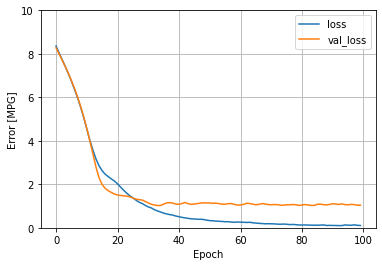

In [39]:
plot_loss(history)

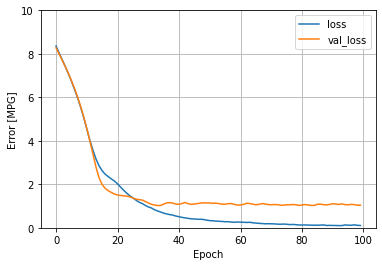

In [40]:
plot_loss(history)

In [56]:
def mikro_model(norm):
      model = keras.Sequential([
      norm,
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
      return model



def small_model(norm):
      model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
      return model


def medium_model(norm):
      model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(regularizer) ),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
      return model


def large_model(norm):
      model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
    
      return model

def scale_model(norm):
      model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(regularizer)),
      layers.Dropout(dropout),
      layers.Dense(1)
      ])
      
      return model

In [57]:
optimizer = tf.optimizers.Adam(learning_rate=lr)

In [58]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(schedul)

In [61]:
def DNN_Pipeline (model):
    
    model.compile(optimizer= optimizer, loss='mean_absolute_error')
    
    history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler),
    verbose=0, epochs=100)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    print(hist.tail(10))
    
    return model

        loss  val_loss        lr  epoch
90  0.158243  1.702474  0.000974     90
91  0.153680  1.708932  0.000974     91
92  0.160357  1.704033  0.000974     92
93  0.150132  1.692261  0.000974     93
94  0.150708  1.694238  0.000974     94
95  0.147603  1.710126  0.000974     95
96  0.145447  1.707724  0.000974     96
97  0.138650  1.675386  0.000974     97
98  0.139797  1.674136  0.000973     98
99  0.135294  1.688042  0.000973     99


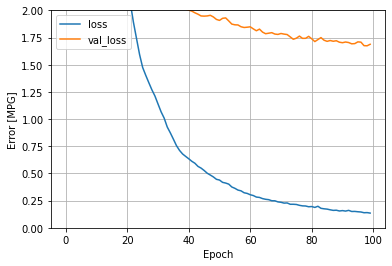

In [65]:
small = DNN_Pipeline(small_model(normalizer))

        loss  val_loss        lr  epoch
90  0.073449  1.243609  0.000983     90
91  0.065309  1.230999  0.000983     91
92  0.062973  1.232756  0.000983     92
93  0.057501  1.237834  0.000983     93
94  0.055549  1.230942  0.000983     94
95  0.059778  1.227881  0.000983     95
96  0.050012  1.227091  0.000982     96
97  0.061178  1.232645  0.000982     97
98  0.048959  1.232342  0.000982     98
99  0.049103  1.234615  0.000982     99


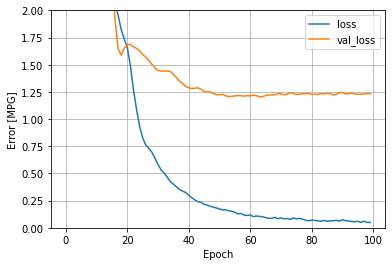

In [63]:
medium = DNN_Pipeline(medium_model(normalizer))

        loss  val_loss        lr  epoch
90  0.098985  1.474359  0.000966     90
91  0.080053  1.474614  0.000965     91
92  0.090007  1.480343  0.000965     92
93  0.068421  1.450835  0.000965     93
94  0.091387  1.500577  0.000965     94
95  0.123439  1.477664  0.000965     95
96  0.114619  1.471519  0.000965     96
97  0.072782  1.485890  0.000965     97
98  0.086953  1.445083  0.000965     98
99  0.099836  1.476581  0.000965     99


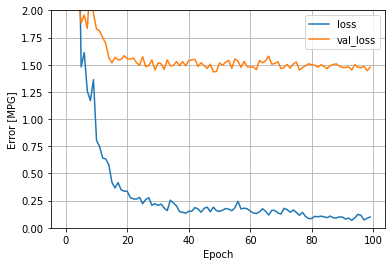

In [66]:
large = DNN_Pipeline(large_model(normalizer))

        loss  val_loss        lr  epoch
90  0.194031  1.531722  0.000957     90
91  0.207984  1.478651  0.000957     91
92  0.318052  1.466070  0.000957     92
93  0.155671  1.505068  0.000957     93
94  0.157874  1.472802  0.000956     94
95  0.141875  1.531571  0.000956     95
96  0.199813  1.502218  0.000956     96
97  0.147055  1.522013  0.000956     97
98  0.100900  1.513094  0.000956     98
99  0.085251  1.510858  0.000956     99


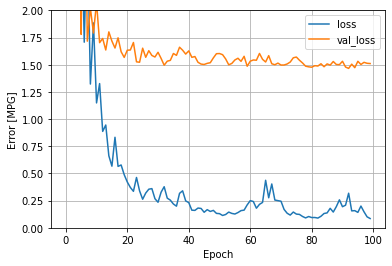

In [67]:
scale = DNN_Pipeline(scale_model(normalizer))

In [69]:
#mikro_predict = mikro.predict(test_features)
small_predict = small.predict(test_features)
medium_predict = medium.predict(test_features)
large_predict = large.predict(test_features)
scale_predict = scale.predict(test_features)

In [74]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(medium_predict,test_labels)   

1.1158912075890435

In [75]:
mean_absolute_error(scale_predict,test_labels)   

1.2331461005740696

In [92]:
print(scale_predict)

[[ 6.6845884]
 [10.782689 ]
 [ 8.416182 ]
 [10.017844 ]
 [ 7.4683704]
 [ 8.584283 ]
 [ 8.230318 ]
 [ 9.013846 ]
 [ 8.739503 ]
 [ 9.401127 ]
 [ 9.820249 ]
 [ 7.4541717]
 [ 7.731168 ]
 [11.059075 ]
 [ 8.352338 ]
 [10.048335 ]
 [ 8.740755 ]
 [11.362262 ]]


In [77]:
print(test_labels)

71    8.9
72    8.8
73    8.3
74    8.4
75    8.6
76    9.0
77    8.5
78    8.2
79    8.7
80    8.4
81    8.0
82    8.5
83    8.1
84    7.9
85    8.9
86    7.8
87    8.4
88    8.3
Name: Rating, dtype: float64


In [78]:
# Rank train datasets

medium.predict(train_features)

array([[ 8.94911  ],
       [ 8.861728 ],
       [ 8.566479 ],
       [ 8.901875 ],
       [ 9.005402 ],
       [ 8.6369095],
       [ 8.198398 ],
       [ 8.591158 ],
       [ 8.926921 ],
       [ 8.799628 ],
       [ 8.77018  ],
       [ 8.109024 ],
       [ 8.087483 ],
       [ 9.241613 ],
       [ 8.610586 ],
       [ 8.594385 ],
       [ 8.619791 ],
       [ 8.816523 ],
       [ 8.227956 ],
       [ 8.821316 ],
       [ 8.610922 ],
       [ 8.544237 ],
       [ 8.63772  ],
       [ 8.552895 ],
       [ 8.221102 ],
       [ 8.543068 ],
       [ 8.996233 ],
       [ 8.63772  ],
       [ 8.894947 ],
       [ 8.400085 ],
       [ 8.683496 ],
       [ 8.786445 ],
       [ 8.548849 ],
       [ 8.635817 ],
       [ 8.744046 ],
       [ 8.632128 ],
       [ 8.587403 ],
       [ 8.888636 ],
       [ 8.453807 ],
       [ 8.715841 ],
       [ 8.534647 ],
       [ 8.625892 ],
       [ 8.637043 ],
       [ 8.39451  ],
       [ 8.508837 ],
       [ 9.078274 ],
       [ 8.723696 ],
       [ 8.53

## Convert Model

In [83]:
import tensorflow as tf

'''
converter = tf.lite.TFLiteConverter.from_keras_model(medium)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
'''

# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = '/content/model'

tf.saved_model.save(medium, export_dir)

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


In [84]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [85]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)  

# Set the optimzations
converter.optimizations = [optimization]   

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert() 

In [87]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

6528

In [91]:
# JS Model

import time
#saved_model_path = "./{}.h5".format(int(time.time()))
saved_model_path = "./{}.h5".format('jsmodel')

medium.save(saved_model_path)

In [95]:
pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 40 kB 2.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [96]:
# JSON
import tensorflowjs as tfjs 

tfjs.converters.save_keras_model(medium,'jsonmodel')

weight count with shape () and dtype int64 was auto converted to the type int32
